In [1]:
import requests
import numpy as np
import pandas as pd
import datetime 
import matplotlib.pyplot as plt

In [2]:
def get_rate(url):
    r = requests.get(url)
    price_dict = r.json()
    interval_prices = price_dict.get('prices')
    start_str = price_dict.get('timeOfFirstPriceLocal')
    start_ts = pd.Timestamp(start_str)
    interval_prices.insert(0, {'duration':'00:00:00'})
    df = pd.DataFrame(interval_prices)
    df.duration = pd.to_timedelta(df.duration)
    df['end_time'] = start_ts + df.duration.cumsum()
    hourly_df = df.set_index('end_time').resample('60T').bfill().reset_index()
    hourly_df['start_time'] = hourly_df['end_time'] - hourly_df['end_time'].diff()
    hourly_df = hourly_df.drop(index = 0)
    return hourly_df.set_index('start_time')
    
url_base = 'https://api.olivineinc.com/i/lbnl/v1/prices/cfh/'
endpoint_dict = {'SummerHDP': url_base + 'SummerHDP',
                'SummerLD-TOU': url_base + 'SummerLD-TOU',
                'SummerMildHDP':url_base + 'SummerMildHDP',
                 'SummerHDPg':url_base + 'SummerHDPg',
                 'FallHDP':url_base + 'FallHDP',
                 'FallHDPg':url_base + 'FallHDPg',
                 'WinterHDP':url_base + 'WinterHDP',
                 'WinterHDPg':url_base + 'WinterHDPg',
                 'SpringHDP':url_base + 'SpringHDP',
                 'SpringHDPg':url_base + 'SpringHDPg',}

prices_by_season = {}
seasons = ['WinterHDP', 'SpringHDP', 'SummerHDP', 'FallHDP']

for season in seasons:
    df = get_rate(endpoint_dict[season])
    df['hour'] = df.index.hour
    df_sorted = df.sort_values(by='hour')
    prices_by_season[season] = list(df_sorted.price)

print(prices_by_season)

{'WinterHDP': [0.0718, 0.0445, 0.0202, 0.011, 0.0331, 0.11, 0.2672, 0.3077, 0.2163, 0.1584, 0.1264, 0.1047, 0.1318, 0.1835, 0.2485, 0.3123, 0.3961, 0.5254, 0.4974, 0.4525, 0.3918, 0.3113, 0.1998, 0.1106], 'SpringHDP': [0.1714, 0.144, 0.1385, 0.1518, 0.1829, 0.2713, 0.4659, 0.5328, 0.28, 0.1158, 0.0398, 0.0196, 0.011, 0.0188, 0.0255, 0.0632, 0.0957, 0.2358, 0.4931, 0.6618, 0.5364, 0.4116, 0.2905, 0.2209], 'SummerHDP': [0.0864, 0.0587, 0.0385, 0.0246, 0.0165, 0.0215, 0.0359, 0.0206, 0.0106, 0.0192, 0.0309, 0.0612, 0.0925, 0.1244, 0.1667, 0.2148, 0.3563, 0.4893, 0.7098, 0.7882, 0.5586, 0.3326, 0.2152, 0.1487], 'FallHDP': [0.2052, 0.1284, 0.0792, 0.0531, 0.0551, 0.1193, 0.2737, 0.27, 0.0916, 0.011, 0.0389, 0.0238, 0.0366, 0.0611, 0.0998, 0.1888, 0.3046, 0.5198, 0.7248, 0.6936, 0.4961, 0.3569, 0.1822, 0.0413]}


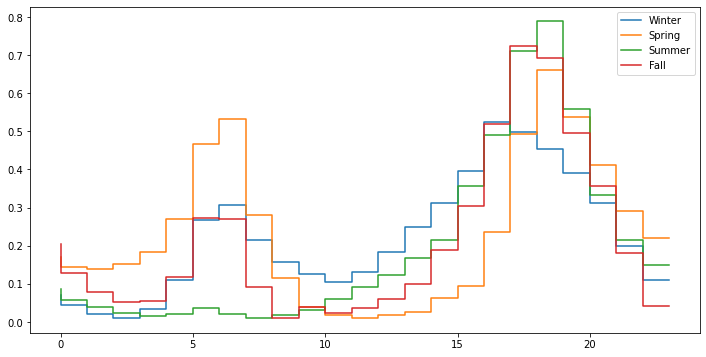

In [3]:
plt.figure(figsize=(12,6))
for season in seasons:
    plt.step(range(24), prices_by_season[season], label=season[:-3])
plt.legend()
plt.show()

In [4]:
# January 1 - March 18: Winter
# March 19 - June 20: Spring
# June 21 - September 21: Summer
# September 22 - December 20: Fall
# December 21 - December 31: Winter

# Build yearly prices
yearly_prices = (31+29+18)*prices_by_season['WinterHDP']
yearly_prices += (13+30+31+20)*prices_by_season['SpringHDP']
yearly_prices += (10+31+31+21)*prices_by_season['SummerHDP']
yearly_prices += (9+31+30+20)*prices_by_season['FallHDP']
yearly_prices += (10)*prices_by_season['FallHDP']